# Computation of magnification factor using pycortex
__To do :__
- [x] fix problem with smaller radius
- [x] compute point image
- [ ] plot data across multiple visual areas
- [ ] check if values correspond to Dumoulin with different radius around vertex
- [ ] make weighting of data (if possible ?)
- [ ] add fitting formulas
- [ ] exclude vertex not in roi (?)
- [ ] save data as nii.gz

In [21]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# General imports
import cortex
import importlib
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
sys.path.append("{}".format(os.getcwd()))
from pycortex_utils import draw_cortex_vertex, set_pycortex_config_file
import nibabel as nb
from tqdm import tqdm

# Define analysis parameters
with open('../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)
xfm_name = analysis_info["xfm_name"]
task = analysis_info["task"]
rois = analysis_info["rois"]
rois = ['V1', 'V2', 'V3']

# Inputs
main_dir = '/home/mszinte/disks/meso_S/data/'
project_dir = 'amblyo_prf'
subject = 'sub-17'

# set folders
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
fit_dir = "{}/{}/derivatives/pp_data/{}/prf/fit".format(main_dir, project_dir, subject)
flatmaps_dir = '{}/{}/derivatives/pp_data/{}/prf/pycortex/flatmaps'.format(main_dir, project_dir, subject)
datasets_dir = '{}/{}/derivatives/pp_data/{}/prf/pycortex/datasets'.format(main_dir, project_dir, subject)
os.makedirs(flatmaps_dir, exist_ok=True)
os.makedirs(datasets_dir, exist_ok=True)
deriv_avg_fn = "{}/{}_task-{}_fmriprep_dct_bold_avg_prf-deriv.nii.gz".format(fit_dir, subject, task)
deriv_avg_loo_fn = "{}/{}_task-{}_fmriprep_dct_bold_loo_avg_prf-deriv.nii.gz".format(fit_dir, subject, task)
deriv_fns = [deriv_avg_fn,deriv_avg_loo_fn]
deriv_fn_labels = ['avg','loo_avg']

# Set pycortex db and colormaps
set_pycortex_config_file(cortex_dir)
importlib.reload(cortex)

# Maps settings
params_num = 10
rsq_idx, rsq_loo_idx, ecc_idx, polar_real_idx, polar_imag_idx , size_idx, \
    amp_idx, baseline_idx, x_idx, y_idx = 0,1,2,3,4,5,6,7,8,9
cmap_polar, cmap_uni, cmap_ecc_size = 'hsv', 'Reds', 'Spectral'
col_offset = 1.0/14.0
cmap_steps = 255

# Load params
deriv_fn = deriv_fns[0]
deriv_mat = nb.load(deriv_fn).get_fdata()

deriv_mat_th = deriv_mat
amp_down =  deriv_mat_th[...,amp_idx] > 0
rsqr_th_down = deriv_mat_th[...,rsq_idx] >= 0.6#analysis_info['rsqr_th'][0]
rsqr_th_up = deriv_mat_th[...,rsq_idx] <= analysis_info['rsqr_th'][1]
size_th_down = deriv_mat_th[...,size_idx] >= analysis_info['size_th'][0]
size_th_up = deriv_mat_th[...,size_idx] <= analysis_info['size_th'][1]
ecc_th_down = deriv_mat_th[...,ecc_idx] >= analysis_info['ecc_th'][0]
ecc_th_up = deriv_mat_th[...,ecc_idx] <= analysis_info['ecc_th'][1]
all_th = np.array((amp_down,rsqr_th_down,rsqr_th_up,size_th_down,size_th_up,ecc_th_down,ecc_th_up)) 
deriv_mat[np.logical_and.reduce(all_th)==False,rsq_idx]=0

# Define settings
vert_dist_th = 2   # distance of vertex to include in mm
rois_analysis = True
if rois_analysis == False: rois = ['whole']

# get surfaces for each hemisphere
surfs = [cortex.polyutils.Surface(*d) for d in cortex.db.get_surf(subject, "flat")]
surf_lh, surf_rh = surfs[0], surfs[1]

# get the vertices number per hemisphere
lh_vert_num, rh_vert_num = surf_lh.pts.shape[0], surf_rh.pts.shape[0]
vert_num = lh_vert_num + rh_vert_num

# get a dicst with the surface vertices contained in each ROI
roi_verts_dict = cortex.utils.get_roi_verts(subject, mask=False)

# mapper from voxels to vertices
mapper = cortex.get_mapper(subject, xfm_name, 'line_nearest', recache=True)

# parameters in vertices
vert_rsq_data = mapper(cortex.Volume(deriv_mat[...,rsq_idx].T, subject, xfm_name)).data
vert_x_data = mapper(cortex.Volume(deriv_mat[...,x_idx].T, subject, xfm_name)).data
vert_y_data = mapper(cortex.Volume(deriv_mat[...,y_idx].T, subject, xfm_name)).data
vert_size_data = mapper(cortex.Volume(deriv_mat[...,size_idx].T, subject, xfm_name)).data
vert_ecc_data = mapper(cortex.Volume(deriv_mat[...,ecc_idx].T, subject, xfm_name)).data

## Adaptation of Benson work : 
https://github.com/noahbenson/cortical-magnification-tutorial/blob/master/work/tutorial.ipynb

## Moving Ring
When cortical magnification is reported, it is often reported as a function of the degrees of eccentricity, e.g., Horton and Hoyt, 1991. This is because by far the biggest change in cortical magnification across the visual field covaries with eccentricity.

To calculate the cortical magnification in terms of an eccentricity
, a straightforward way is pick some ring of the visual field from eccentricity to eccentricity and to count up the total surface area of all the vertices in V1 (or another visual area) that have pRF centers inside the ring, then to divide that area by the area of the ring. Using scipy's spatial hashes, we can do this efficiently for any query; we can even return quantile data efficiently, as in the following example.

100%|██████████| 250/250 [00:05<00:00, 45.84it/s]


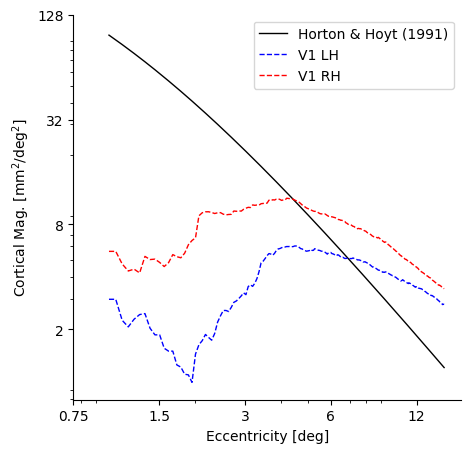

In [40]:
min_ecc = 1
max_ecc = 15
steps = 250
ring_rads = np.linspace(min_ecc, max_ecc, steps)
cmf = np.zeros((steps,3))
roi = 'V1'
roi_idx = np.zeros(vert_num)
roi_idx[roi_verts_dict[roi]] = 1
hemi_idx = np.zeros(vert_num)*np.nan
hemi_idx[np.arange(0,lh_vert_num)] = 1 # rh
hemi_idx[np.arange(lh_vert_num,vert_num)] = 2 #lh

with tqdm(total=steps) as pbar:
    for ring_num, ring_rad in enumerate(ring_rads):

        # compute indices
        eccs_not_null_idx = vert_ecc_data!=0
        eccs_ring_idx = vert_ecc_data<=ring_rad
        eccs_not_null_ring_roi_lh_idx = (eccs_not_null_idx==1) & (eccs_ring_idx==1) & (roi_idx==1) & (hemi_idx==1)
        eccs_not_null_ring_roi_rh_idx = (eccs_not_null_idx==1) & (eccs_ring_idx==1) & (roi_idx==1) & (hemi_idx==2)
        
        # left hemisphere
        if np.sum(eccs_not_null_ring_roi_lh_idx==True) > 0:
            eccs_lh = vert_ecc_data[eccs_not_null_ring_roi_lh_idx]
            visual_area_lh = np.pi / 2 * (np.max(eccs_lh, axis=0)**2 - np.min(eccs_lh, axis=0)**2)
            surf_area_lh = np.sum(surf_lh.create_subsurface(
                vertex_mask=eccs_not_null_ring_roi_lh_idx[:lh_vert_num]).face_areas)
        else:
            visual_area_lh = np.nan
            surf_area_lh = np.nan
        
        # right hemisphere
        if np.sum(eccs_not_null_ring_roi_rh_idx==True) > 0:
            eccs_rh = vert_ecc_data[eccs_not_null_ring_roi_rh_idx]
            visual_area_rh = np.pi / 2 * (np.max(eccs_rh, axis=0)**2 - np.min(eccs_rh, axis=0)**2)
            surf_area_rh = np.sum(surf_rh.create_subsurface(
                vertex_mask=eccs_not_null_ring_roi_rh_idx[lh_vert_num:]).face_areas)
        else:
            visual_area_rh = np.nan
            surf_area_rh = np.nan
            
        # compute sum and cmf
        visual_area = visual_area_lh + visual_area_rh
        surf_area = surf_area_lh + surf_area_rh
        cmf[ring_num] = (surf_area_lh / visual_area_lh, surf_area_rh / visual_area_rh, surf_area / visual_area)
        
        pbar.update(1)
pbar.close()

import matplotlib as mpl
import matplotlib.pyplot as plt

# Make the figure:
(fig, ax) = plt.subplots(1,1, figsize=(5,5), dpi=100)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

x = ring_rads
ax.plot(x, (17.3 / (0.75 + x))**2, 'k-', lw=1, label='Horton & Hoyt (1991)')
ax.plot(x, cmf[:,0], 'b--', lw=1, label='{} LH'.format(roi))
ax.plot(x, cmf[:,1], 'r--', lw=1, label='{} RH'.format(roi))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xticks([0.75, 1.5, 3, 6, 12])
ax.set_xticklabels([0.75, 1.5, 3, 6, 12])
ax.set_yticks([2,8,32,128])
ax.set_yticklabels([2,8,32,128])
ax.set_xlabel('Eccentricity [deg]')
ax.set_ylabel(r'Cortical Mag. [mm$^2$/deg$^2$]')
ax.legend();

## **Harvey, B. M. & Dumoulin, S. O.**  
#### The relationship between cortical magnification factor and population receptive field size in human visual cortex: constancies in cortical architecture. 
#### _The Journal of Neuroscience_ 31, 13604–13612 (2011).
  
_We determined the CMF for every voxel on the gray–white matter
border independently. All analysis of pRF, CMF, and point image was
therefore restricted to voxels on the gray–white matter border. Gray
matter thickness was ignored, effectively treating the gray–white matter
border as the cortical surface. At each cortical location, we computed the
distance (in millimeters) to neighboring locations along the cortical sur-
face. To compute the CMF, this cortical distance was divided by the
change in preferred pRF location (degrees of visual angle) of the same
cortical locations. Neighboring voxels with poor pRF model fits (vari-
ance explained 30%) were removed from this computation, as were
voxels outside the ROI. The population point image was computed by
multiplying the CMF and pRF size estimates for each cortical location.
This technique estimates the CMF and point image for each individual
cortical location._

## **Clavagnier, S., Dumoulin, S. O. & Hess, R. F.**
#### Is the Cortical Deficit in Amblyopia Due to Reduced Cortical Magnification, Loss of Neural Resolution, or Neural Disorganization? 
#### _The Journal of Neuroscience_ 35, 14740–14755 (2015).
  
_To determine cortical magnification factor (CMF), the fMRI data first had
to be projected onto a 2D cortical surface (Harvey and Dumoulin, 2011).
The distances between each location (mesh vertices) and their neighbor-
ing locations could then be computed in millimeters. Local CMF was 
calculated by dividing the mean cortical distance between the vertices
and their neighboring vertices by the mean difference of their preferred
pRF locations (in degree of visual angle). CMFs estimated were binned by
eccentricity (every 0.25°). The population point image (pPI) was com-
puted by multiplying the CMFs and pRF sizes estimated for each cortical
location._

In [4]:
# create empty results
vert_cmf = np.zeros(vert_num)*np.nan
vert_ppi = np.zeros(vert_num)*np.nan

for roi in rois:
    # find ROI vertex
    if roi == 'whole':
        roi_vert_lh_idx = np.arange(0,lh_vert_num)
        roi_vert_rh_idx = np.arange(lh_vert_num, vert_num)
    else:
        roi_vert_lh_idx = roi_verts_dict[roi][roi_verts_dict[roi]<lh_vert_num]
        roi_vert_rh_idx = roi_verts_dict[roi][roi_verts_dict[roi]>=lh_vert_num]
    roi_surf_lh_idx = roi_vert_lh_idx
    roi_surf_rh_idx = roi_vert_rh_idx-lh_vert_num

    # get mean distance of surounding vertices included in threshold
    vert_lh_rsq, vert_lh_size = vert_rsq_data[:lh_vert_num], vert_size_data[:lh_vert_num]
    vert_lh_x, vert_lh_y = vert_x_data[:lh_vert_num], vert_y_data[:lh_vert_num]
    vert_rh_rsq, vert_rh_size = vert_rsq_data[lh_vert_num:], vert_size_data[lh_vert_num:]
    vert_rh_x, vert_rh_y = vert_x_data[lh_vert_num:], vert_y_data[lh_vert_num:]

    for hemi in ['lh','rh']:
        if hemi == 'lh':
            surf = surf_lh
            roi_vert_idx, roi_surf_idx = roi_vert_lh_idx, roi_surf_lh_idx
            vert_rsq, vert_x, vert_y, vert_size = vert_lh_rsq, vert_lh_x, vert_lh_y, vert_lh_size
        elif hemi == 'rh':
            surf = surf_rh
            roi_vert_idx, roi_surf_idx = roi_vert_rh_idx, roi_surf_rh_idx
            vert_rsq, vert_x, vert_y, vert_size = vert_rh_rsq, vert_rh_x, vert_rh_y, vert_rh_size

        desc = 'ROI -> {} / Hemisphere -> {}'.format(roi, hemi)
        good_vert_num = roi_surf_idx[vert_rsq[roi_surf_idx]>0].size
        with tqdm(total=good_vert_num, desc=desc) as pbar:
            for i, (vert_idx, surf_idx) in enumerate(zip(roi_vert_idx, roi_surf_idx)):

                if vert_rsq[surf_idx] > 0:

                    # get geodesic distances (mm)
                    try :
                        geo_patch = surf.get_geodesic_patch(radius=vert_dist_th, vertex=surf_idx)
                    except Exception as e:
                        print("Vertex #{}: error: {} within {} mm".format(vert_idx, e, vert_dist_th))
                        geo_patch['vertex_mask'] = np.zeros(surf.pts.shape[0]).astype(bool)
                        geo_patch['geodesic_distance'] = []
                    
                    vert_dist_th_idx  = geo_patch['vertex_mask']

                    # compute average geodesic distance excluding distance to itself (see [1:])
                    vert_geo_dist_avg = np.nanmean(geo_patch['geodesic_distance'][1:])
                    
                    # get prf parameters of vertices in geodesic distance threshold
                    vert_ctr_x, vert_ctr_y = vert_x[surf_idx], vert_y[surf_idx]
                    vert_dist_th_idx[surf_idx] = False
                    vert_srd_x, vert_srd_y = np.nanmean(vert_x[vert_dist_th_idx]), np.nanmean(vert_y[vert_dist_th_idx])

                    # compute prf center suround distance (deg)
                    vert_prf_dist = np.sqrt((vert_ctr_x - vert_srd_x)**2 + (vert_ctr_y - vert_srd_y)**2)

                    # compute cortical magnification in mm/deg (surface distance / pRF positon distance)
                    vert_cmf[vert_idx] = vert_geo_dist_avg/vert_prf_dist
                    
                    # compute population point image 
                    vert_ppi[vert_idx] = vert_cmf[vert_idx] * vert_size[surf_idx]
                    
                    pbar.update(1)

        pbar.close()

ROI -> V3 / Hemisphere -> rh: 100%|██████████| 223/223 [00:07<00:00, 31.08it/s]


In [ ]:
# # Convert back to volume
# vol_cmf_mm_deg = mapper.backwards(vert_cmf_mm_deg)

# # plot mean distance on Vertex2D
# dist_rsq_map = cortex.Vertex2D(dim1=vert_cmf_mm_deg, dim2=vert_rsq_data, subject=subject, cmap='hot_alpha', vmin=0, vmax=5, vmin2=0, vmax2=1)
# cortex.quickshow(dist_rsq_map)
# plt.show()

# # plot mean distance on Volume RGB
# alpha = deriv_mat[...,rsq_idx]
# param_cmf = {'subject': subject, 'xfmname': xfm_name,
#              'data': vol_cmf_mm_deg, 'cmap': 'hot', 'alpha': alpha, 'vmin': 0, 'vmax': 3,'cbar': 'ecc', 'cortex_type': 'VolumeRGB',
#              'description': '{} CMF'.format(task), 'curv_brightness': 1, 'curv_contrast': 0.1}
# volume_cmf = draw_cortex_vertex(**param_cmf)

In [46]:
import pandas as pd
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px


# define roi index (V1 = 0-)
vert_roi_data = np.zeros(vert_num)
for roi_num, roi in enumerate(rois):
    vert_roi_data[roi_verts_dict[roi]] = [roi_num]

# define dataframe
data_mat = np.vstack((vert_roi_data, vert_rsq_data, vert_x_data, vert_y_data, 
                      vert_size_data, vert_ecc_data, vert_cmf, vert_ppi)).T

df = pd.DataFrame(data=data_mat,
                  columns=['roi_num', 'rsq', 'x', 'y', 'size', 
                           'ecc', 'cmf', 'ppi'])


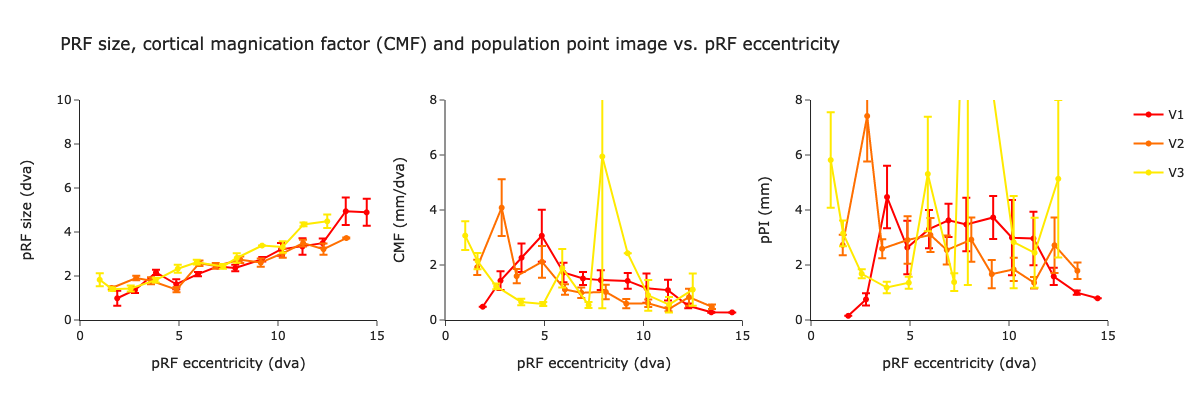

In [51]:
fig = make_subplots(rows=1, cols=3)
roi_colors = px.colors.sequential.Rainbow_r

for roi_num, roi in enumerate(rois):
    #get bins
    df_roi = df.loc[(df.rsq>=0.3) & (df.roi_num==roi_num)]
    ecc_min_bins, ecc_max_bins, ecc_step_bins = 0, 15, 15
    bins = np.linspace(ecc_min_bins, ecc_max_bins, ecc_step_bins)
    df_bin = df_roi.groupby(pd.cut(df_roi['ecc'], bins=bins))

    # Make Figure
    fig.add_trace(go.Scatter(x=df_bin.mean().ecc, y=df_bin.mean()['size'], error_y=dict(type='data', array=df_bin.sem()['size']),
                             name = roi, legendgroup=roi, showlegend=True, line_color = roi_colors[roi_num]), row=1, col=1)
    fig.add_trace(go.Scatter(x=df_bin.mean().ecc, y=df_bin.mean().cmf, error_y=dict(type='data', array=df_bin.sem().cmf),
                             legendgroup=roi, showlegend=False, line_color =  roi_colors[roi_num]), row=1, col=2)
    fig.add_trace(go.Scatter(x=df_bin.mean().ecc, y=df_bin.mean().ppi, error_y=dict(type='data', array=df_bin.sem().ppi),
                             legendgroup=roi, showlegend=False, line_color =  roi_colors[roi_num]), row=1, col=3)

fig.update_layout(template= 'simple_white',
                  xaxis_title="pRF eccentricity (dva)", xaxis_range = [ecc_min_bins, ecc_max_bins],
                  xaxis2_title="pRF eccentricity (dva)", xaxis2_range = [ecc_min_bins, ecc_max_bins],
                  xaxis3_title="pRF eccentricity (dva)", xaxis3_range = [ecc_min_bins, ecc_max_bins],
                  yaxis_title="pRF size (dva)", yaxis_range = [0, 10],
                  yaxis2_title="CMF (mm/dva)", yaxis2_range = [0, 8],
                  yaxis3_title="pPI (mm)", yaxis3_range = [0, 8])

title = "PRF size, cortical magnication factor (CMF) and population point image vs. pRF eccentricity"
fig.update_layout(height=400, width=1200, title_text=title)
fig.show()

In [28]:
vert_roi_data = np.zeros(data_mat.size)*np.nan
for roi_num, rois in enumerate(rois):
    vert_roi_data[roi_verts_dict[roi]] = np.zeros(roi_verts_dict[roi].size)+roi_num

In [25]:
['V1']*roi_verts_dict['V1'].shape[0]

['V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',
 'V1',

In [22]:
vert_roi_data

['',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
 '',
